In [1]:
import pandas as pd
import numpy as np
import os, random
from matplotlib import pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [2]:
volmeta = pd.read_csv('Data/updatedvolumemetadata.tsv', sep = '\t')

In [3]:
volmeta.head()

,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,enumcron,gbindex,...,contents,instances,genre,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed
0,loc.ark+=13960=t5p851b8s,"Reid, Stuart J.",NaN,Lord John Russell,1895,NaN,New York;Harper & brothers;1,"Reid, Stuart J. | Lord John Russell",<blank>,27553,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
1,hvd.32044070870779,"Smiles, Samuel,",NaN,Lives of the engineers,1879,NaN,London;J. Murray;1874-1877.,"Smiles, Samuel | Lives of the Engineers",v. 5,27710,...,NaN,NaN,bio | short,NaN,m,NaN,"2 people, mixed together (not one per chapter)",morgan,gutenbiotrimmed,Trimmed
2,mdp.39015005892362,"Cruttwell, Maud.",NaN,Luca Signorelli,1899,NaN,London;G. Bell & sons;1899.,"Cruttwell, Maud | Luca Signorelli",<blank>,27759,...,NaN,NaN,bio,NaN,f,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
3,mdp.39015051108531,"Bettany, George Thomas,",NaN,Life of Charles Darwin,1887,NaN,London;W. Scott;1887.,"Bettany, George Thomas | Life of Charles Darwin",<blank>,28380,...,NaN,NaN,bio,NaN,m,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
4,loc.ark+=13960=t6b27z54n,"Gay, Sydney Howard,",NaN,James Madison,1889,NaN,"Boston;New York;Houghton, Mi","Gay, Sydney Howard | James Madison",<blank>,28992,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed


In [4]:
cleanfiles = [x for x in os.listdir('D:\DH collaborative\OCR\cleannarratives\\')
              if x.endswith('.txt')]
dirtyfiles = [x for x in os.listdir('D:\DH collaborative\OCR\dirtynarratives\\')
               if x.endswith('.txt')]

In [5]:
print("We have " + str(len(cleanfiles)) + " clean chunks, and")
print(str(len(dirtyfiles)), " dirty ones.")

We have 2489 clean chunks, and
2610  dirty ones.


In [6]:
def get_gbindex(filename):
    return filename.split('_')[0]

gbdict = dict()

for filename in cleanfiles:
    gbindex = get_gbindex(filename)
    if gbindex not in gbdict:
        gbdict[gbindex] = []
    gbdict[gbindex].append(filename)

gbset = set(gbdict.keys())

In [7]:
print("We have " + str(len(gbset)) + " separate clean volumes that have been chunked.")

We have 423 separate clean volumes that have been chunked.


In [8]:
ourtitles = volmeta.loc[volmeta['gbindex'].isin(gbset), : ]
ourtitles.shape

(423, 24)

In [9]:
def create_chunkframe(filelist, volmeta):
    
    chunkids = []
    gbindices = []
    
    for filename in filelist:
        chunkids.append(filename.replace('.txt', ''))
        gbindices.append(get_gbindex(filename))
    
    df = pd.DataFrame({'chunkid': chunkids, 'gbindex': gbindices})
    
    chunkmeta = df.merge(volmeta, how = 'inner', on = 'gbindex')
    
    return chunkmeta

In [10]:
cleanmeta = create_chunkframe(cleanfiles, ourtitles)
cleanmeta.set_index('chunkid', inplace = True)
cleanmeta.shape

(2489, 24)

In [11]:
dirtymeta = create_chunkframe(dirtyfiles, ourtitles)
dirtymeta.set_index('chunkid', inplace = True)
dirtymeta.shape

(2610, 24)

In [12]:
clean_rootdir = 'D:\DH collaborative\OCR\cleannarratives\\'

clean_paths = []

for chunk_id in cleanmeta.index:
    clean_paths.append(clean_rootdir + chunk_id + '.txt')

In [13]:
clean_model_chunk_ids = cleanmeta.index

vectorizer = CountVectorizer(input = 'filename', min_df = .02)
sparse_clean_counts = vectorizer.fit_transform(clean_paths) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
clean_wordcounts = pd.DataFrame(sparse_clean_counts.toarray(), index = clean_model_chunk_ids, 
                            columns = vectorizer.get_feature_names())
clean_wordcounts.head()

,000,10,100,10th,11,11th,12,12th,13,13th,...,youthful,youths,zeal,zealand,zealous,zealously,zenith,zest,zigzag,zone
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,0,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1079_1,0,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1079_10,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
1079_11,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1079_12,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
dirty_rootdir = 'D:\DH collaborative\OCR\dirtynarratives\\'

dirty_paths = []

for chunk_id in dirtymeta.index:
    dirty_paths.append(dirty_rootdir + chunk_id + '.txt')

dirty_model_chunk_ids = dirtymeta.index
    
vectorizer = CountVectorizer(input = 'filename', min_df = .02)
sparse_dirty_counts = vectorizer.fit_transform(dirty_paths) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
dirty_wordcounts = pd.DataFrame(sparse_dirty_counts.toarray(), index = dirty_model_chunk_ids, 
                            columns = vectorizer.get_feature_names())
dirty_wordcounts.head()

,00,000,01,10,100,101,102,103,104,105,...,ſwore,ſyſtem,ſº,ﬁlled,ﬁnd,ﬁne,ﬁre,ﬁrst,ﬁve,ﬁxed
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,1,0,0,4,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1079_1,0,0,0,3,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
1079_10,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1079_11,0,0,0,3,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1079_12,0,0,0,2,0,0,0,0,0,0,...,1,3,0,0,0,0,0,0,0,0


In [15]:
clean_rowsums = clean_wordcounts.sum(axis = 'columns')
clean_freqs = clean_wordcounts.divide(clean_rowsums, axis = 'rows')

In [16]:
print(clean_freqs.shape)
clean_freqs.head()

(2489, 17316)


,000,10,100,10th,11,11th,12,12th,13,13th,...,youthful,youths,zeal,zealand,zealous,zealously,zenith,zest,zigzag,zone
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000074,0.000000,0.000074,0.0,...,0.0,0.0,0.000074,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_1,0.0,0.000158,0.0,0.0,0.000079,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_10,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000158,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_11,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000074,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_12,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000078,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
dirty_rowsums = dirty_wordcounts.sum(axis = 'columns')
dirty_freqs = dirty_wordcounts.divide(dirty_rowsums, axis = 'rows')

In [18]:
print(dirty_freqs.shape)
dirty_freqs.head()

(2610, 20109)


,00,000,01,10,100,101,102,103,104,105,...,ſwore,ſyſtem,ſº,ﬁlled,ﬁnd,ﬁne,ﬁre,ﬁrst,ﬁve,ﬁxed
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,0.000077,0.0,0.0,0.000309,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_1,0.000000,0.0,0.0,0.000240,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_10,0.000000,0.0,0.0,0.000078,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000078,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_11,0.000000,0.0,0.0,0.000232,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_12,0.000000,0.0,0.0,0.000154,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000077,0.000231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
clean_regr = clean_freqs.join(cleanmeta['latestcomp'], on = 'chunkid', how = 'left')
print(clean_regr.shape)
clean_regr.head()

(2489, 17317)


,000,10,100,10th,11,11th,12,12th,13,13th,...,youths,zeal,zealand,zealous,zealously,zenith,zest,zigzag,zone,latestcomp
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000074,0.000000,0.000074,0.0,...,0.0,0.000074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1768
1079_1,0.0,0.000158,0.0,0.0,0.000079,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1768
1079_10,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1768
1079_11,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1768
1079_12,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000078,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1768


In [20]:
dirty_regr = dirty_freqs.join(dirtymeta['latestcomp'], on = 'chunkid', how = 'left')
print(dirty_regr.shape)
dirty_regr.head()

(2610, 20110)


,00,000,01,10,100,101,102,103,104,105,...,ſyſtem,ſº,ﬁlled,ﬁnd,ﬁne,ﬁre,ﬁrst,ﬁve,ﬁxed,latestcomp
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,0.000077,0.0,0.0,0.000309,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1768
1079_1,0.000000,0.0,0.0,0.000240,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1768
1079_10,0.000000,0.0,0.0,0.000078,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1768
1079_11,0.000000,0.0,0.0,0.000232,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1768
1079_12,0.000000,0.0,0.0,0.000154,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1768


In [21]:
clean_features = clean_regr.drop('latestcomp', axis = 1)
clean_keys = clean_regr['latestcomp']
clean_train_features, clean_test_features, clean_train_keys, clean_test_keys = train_test_split(clean_features, clean_keys, test_size=0.25)
dirty_features = dirty_regr.drop('latestcomp', axis = 1)
dirty_keys = dirty_regr['latestcomp']
dirty_train_features, dirty_test_features, dirty_train_keys, dirty_test_keys = train_test_split(dirty_features, dirty_keys, test_size=0.25)

In [22]:
print('Clean training set: ', clean_train_features.shape)
print('Clean test set: ', clean_test_features.shape)
print('Hathi training set: ', dirty_train_features.shape)
print('Hathi testing set: ', dirty_test_features.shape)

Clean training set:  (1866, 17316)
Clean test set:  (623, 17316)
Hathi training set:  (1957, 20109)
Hathi testing set:  (653, 20109)


In [23]:
resultarray = []

featureoptions = [1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000]
alphaoptions = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
    
for featurecount in featureoptions:
    docfreqs = []
    for col in clean_train_features.columns:
        docfreqs.append((sum(clean_train_features[col] > 0), col))
    docfreqs.sort()
    features = [x[1] for x in docfreqs[-featurecount: ]]  # because sorted ascending 
    model_features = clean_train_features.loc[ : , features]
    
    resultrow = []
    
    for alpha_param in alphaoptions:
        clf = Ridge(alpha = alpha_param)
        kf = KFold(n_splits=10, shuffle=True)
        mean_score = 0
        for train_index, test_index in kf.split(clean_train_features, clean_train_keys):
            X_train = model_features.iloc[train_index, :]
            X_test = model_features.iloc[test_index, :]
            y_train = clean_train_keys.iloc[train_index]
            y_test =clean_train_keys.iloc[test_index]
            clf.fit(X_train, y_train)
            clean_preds = clf.predict(X_test)
            clean_diffs = clean_preds - y_test
            clean_absolute_diffs = np.abs(clean_diffs)
            fold_mean = clean_absolute_diffs.mean()
            mean_score += fold_mean
        mean_score = mean_score/10
        resultrow.append(mean_score)
        print(featurecount, alpha_param, mean_score)
    
    resultarray.append(resultrow)

1000 1 43.17199236241023
1000 0.1 34.38301723018799
1000 0.01 24.68901257123496
1000 0.001 17.892573420128777
1000 0.0001 15.038387718820326
1000 1e-05 16.3193384739108
1000 1e-06 19.900186350951934
1000 1e-07 21.001524511756752
1000 1e-08 21.38097402857243
3000 1 43.098592730312575
3000 0.1 34.114867683523364
3000 0.01 24.02073622178427
3000 0.001 16.629878950501745
3000 0.0001 13.230599526440415
3000 1e-05 14.161790189465762
3000 1e-06 16.14223962033889
3000 1e-07 17.51054733601329
3000 1e-08 17.46028519423316
5000 1 43.12090227808429
5000 0.1 34.145490889564144
5000 0.01 23.814089613021864
5000 0.001 16.316770776448855
5000 0.0001 13.06893252819049
5000 1e-05 13.18401129697104
5000 1e-06 14.156173049921838
5000 1e-07 14.57193499954143
5000 1e-08 14.496974421672169
7000 1 43.12611205373908
7000 0.1 34.06734801504632
7000 0.01 23.744268759914206
7000 0.001 16.173486355373676
7000 0.0001 12.638355989243568
7000 1e-05 12.5581376168777
7000 1e-06 13.208548879070142
7000 1e-07 13.26691637

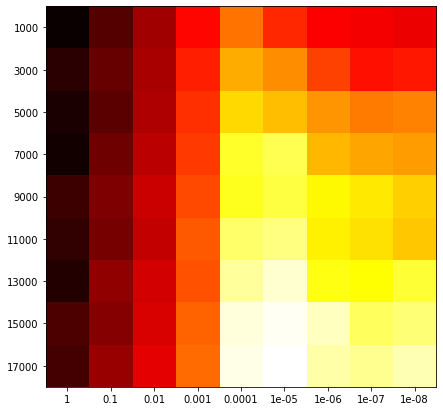

In [24]:
resultarray = np.array(resultarray)
thearrayshape = resultarray.shape
resarray = rankdata(resultarray).reshape(thearrayshape)  

fig, ax = plt.subplots(figsize=(7,7))

ax.imshow(resarray, cmap='hot_r', aspect = 'auto')
plt.yticks(ticks = [x for x in range(len(featureoptions))], labels = featureoptions)
thexlabels = [str(x) for x in alphaoptions]
plt.xticks(ticks = [x for x in range(len(alphaoptions))], labels = thexlabels)
plt.show()

In [25]:
minerror = np.where(resarray == np.amin(resarray))
print(featureoptions[minerror[0][0]], alphaoptions[minerror[1][0]])

17000 1e-05


In [26]:
docfreqs = []
for col in clean_train_features.columns:
    docfreqs.append((sum(clean_train_features[col] > 0), col))
docfreqs.sort()
features = [x[1] for x in docfreqs[-17000: ]]  # because sorted ascending 
model_features = clean_train_features.loc[ : , features]
test_features = clean_test_features.loc[ : , features]

clf = Ridge(alpha = 0.00001)
clean_train_preds = cross_val_predict(clf, model_features, clean_train_keys, cv = 10) 

clf.fit(model_features, clean_train_keys)
clean_test_preds = clf.predict(test_features)
clean_test_diffs = clean_test_preds - clean_test_keys
clean_test_absolute_diffs = np.abs(clean_test_diffs)
clean_test_absolute_diffs.mean()

12.438914928039589

In [27]:
resultarray = []

featureoptions = [1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000]
alphaoptions = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
    
for featurecount in featureoptions:
    docfreqs = []
    for col in dirty_train_features.columns:
        docfreqs.append((sum(dirty_train_features[col] > 0), col))
    docfreqs.sort()
    features = [x[1] for x in docfreqs[-featurecount: ]]  # because sorted ascending 
    model_features = dirty_train_features.loc[ : , features]
    
    resultrow = []
    
    for alpha_param in alphaoptions:
        clf = Ridge(alpha = alpha_param)
        kf = KFold(n_splits=10, shuffle=True)
        mean_score = 0
        for train_index, test_index in kf.split(dirty_train_features, dirty_train_keys):
            X_train = model_features.iloc[train_index, :]
            X_test = model_features.iloc[test_index, :]
            y_train = dirty_train_keys.iloc[train_index]
            y_test =dirty_train_keys.iloc[test_index]
            clf.fit(X_train, y_train)
            dirty_preds = clf.predict(X_test)
            dirty_diffs = dirty_preds - y_test
            dirty_absolute_diffs = np.abs(dirty_diffs)
            fold_mean = dirty_absolute_diffs.mean()
            mean_score += fold_mean
        mean_score = mean_score/10
        resultrow.append(mean_score)
        print(featurecount, alpha_param, mean_score)
    
    resultarray.append(resultrow)

1000 1 43.24848806233477
1000 0.1 33.34220345515463
1000 0.01 23.400560912351473
1000 0.001 17.56731093141091
1000 0.0001 14.672184846627179
1000 1e-05 16.008557706636548
1000 1e-06 18.981455799776466
1000 1e-07 19.892021988728622
1000 1e-08 20.003805957427513
3000 1 43.1944710925949
3000 0.1 33.08198988566596
3000 0.01 22.87909063719132
3000 0.001 16.44430171272774
3000 0.0001 13.121973037356298
3000 1e-05 13.989044483800148
3000 1e-06 17.34428757284714
3000 1e-07 19.031581370161945
3000 1e-08 19.350146469497243
5000 1 43.17273865074024
5000 0.1 33.01914363086195
5000 0.01 22.66281101881439
5000 0.001 15.883827792720627
5000 0.0001 12.5622407196524
5000 1e-05 12.825327920942746
5000 1e-06 14.09206464619974
5000 1e-07 14.742764171021992
5000 1e-08 14.529708991281183
7000 1 43.026428843364044
7000 0.1 32.45373785359713
7000 0.01 22.061121824526207
7000 0.001 15.661324749435773
7000 0.0001 12.193795189284554
7000 1e-05 12.160330829471025
7000 1e-06 12.92701666184866
7000 1e-07 12.9159170

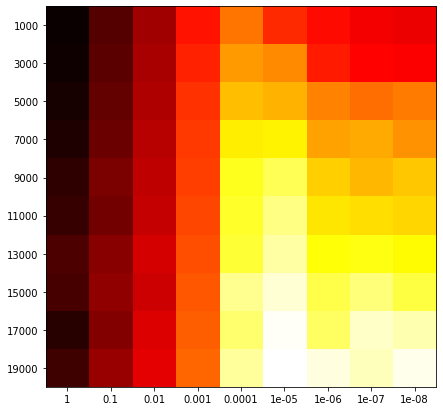

In [28]:
resultarray = np.array(resultarray)
thearrayshape = resultarray.shape
resarray = rankdata(resultarray).reshape(thearrayshape)  

fig, ax = plt.subplots(figsize=(7,7))

ax.imshow(resarray, cmap='hot_r', aspect = 'auto')
plt.yticks(ticks = [x for x in range(len(featureoptions))], labels = featureoptions)
thexlabels = [str(x) for x in alphaoptions]
plt.xticks(ticks = [x for x in range(len(alphaoptions))], labels = thexlabels)
plt.show()

In [29]:
minerror = np.where(resarray == np.amin(resarray))
print(featureoptions[minerror[0][0]], alphaoptions[minerror[1][0]])

19000 1e-05


In [30]:
docfreqs = []
for col in dirty_train_features.columns:
    docfreqs.append((sum(dirty_train_features[col] > 0), col))
docfreqs.sort()
features = [x[1] for x in docfreqs[-19000: ]]  # because sorted ascending 
model_features = dirty_train_features.loc[ : , features]
test_features = dirty_test_features.loc[ : , features]

clf = Ridge(alpha = 0.00001)
dirty_train_preds = cross_val_predict(clf, model_features, dirty_train_keys, cv = 10) 

clf.fit(model_features, dirty_train_keys)
dirty_test_preds = clf.predict(test_features)
dirty_test_diffs = dirty_test_preds - dirty_test_keys
dirty_test_absolute_diffs = np.abs(dirty_test_diffs)
dirty_test_absolute_diffs.mean()

10.793118975121468

In [31]:
clean_train_diffs = clean_train_preds - clean_train_keys
clean_diffs = np.append(clean_train_diffs, clean_test_diffs)
clean_absolute_diffs = np.abs(clean_diffs)
print(clean_diffs.mean())
print(clean_absolute_diffs.mean())

0.11423526706447487
12.020350685974211


In [32]:
dirty_train_diffs = dirty_train_preds - dirty_train_keys
dirty_diffs = np.append(dirty_train_diffs, dirty_test_diffs)
dirty_absolute_diffs = np.abs(dirty_diffs)
print(dirty_diffs.mean())
print(dirty_absolute_diffs.mean())

-0.03794404445041505
10.942075041561813


In [33]:
clean_gbi = [get_gbindex(x) for x in clean_regr.index]
clean_df = pd.DataFrame({'chunkid': list(cleanmeta.index),
                         'gbindex': clean_gbi, 'clean_diffs': clean_diffs, 'clean_abs_diffs': clean_absolute_diffs})
print(clean_df.shape)
clean_df.head()

(2489, 4)


,chunkid,gbindex,clean_diffs,clean_abs_diffs
0,1079_0,1079,-5.711071,5.711071
1,1079_1,1079,-18.373569,18.373569
2,1079_10,1079,-8.017457,8.017457
3,1079_11,1079,15.705570,15.705570
4,1079_12,1079,-3.525556,3.525556


In [34]:
dirty_gbi = [get_gbindex(x) for x in dirty_regr.index]
dirty_df = pd.DataFrame({'chunkid': list(dirtymeta.index),
                         'gbindex': dirty_gbi, 'dirty_diffs': dirty_diffs, 'dirty_abs_diffs': dirty_absolute_diffs})
print(dirty_df.shape)
dirty_df.head()

(2610, 4)


,chunkid,gbindex,dirty_diffs,dirty_abs_diffs
0,1079_0,1079,-13.529180,13.529180
1,1079_1,1079,7.397690,7.397690
2,1079_10,1079,2.339294,2.339294
3,1079_11,1079,5.316961,5.316961
4,1079_12,1079,2.597009,2.597009


In [35]:
meandf = clean_df.groupby('gbindex').mean()
print(meandf.shape)
meandf.head()

# here the clean_abs_diffs is not the absolute value of clean diffs
# since different chunks of a text could be predicted to different directions

(423, 2)


,clean_diffs,clean_abs_diffs
gbindex,,
1079,0.706210,12.663804
11030,8.555277,11.459754
12259,-4.413478,13.475144
12669,-2.634226,7.998070
15042,-18.501925,18.501925


In [36]:
dirty_df = dirty_df.merge(meandf, on = 'gbindex').set_index('chunkid')
dirty_df['diffs_divergence'] = dirty_df['dirty_diffs'] - dirty_df['clean_diffs']
dirty_df['divergence_of_abs_diffs'] = dirty_df['dirty_abs_diffs'] - dirty_df['clean_abs_diffs']
print(dirty_df.shape)
dirty_df.head()

(2610, 7)


,gbindex,dirty_diffs,dirty_abs_diffs,clean_diffs,clean_abs_diffs,diffs_divergence,divergence_of_abs_diffs
chunkid,,,,,,,
1079_0,1079,-13.529180,13.529180,0.70621,12.663804,-14.235390,0.865376
1079_1,1079,7.397690,7.397690,0.70621,12.663804,6.691480,-5.266114
1079_10,1079,2.339294,2.339294,0.70621,12.663804,1.633084,-10.324510
1079_11,1079,5.316961,5.316961,0.70621,12.663804,4.610751,-7.346842
1079_12,1079,2.597009,2.597009,0.70621,12.663804,1.890799,-10.066795


In [37]:
print(dirty_df['diffs_divergence'].mean())
print(dirty_df['divergence_of_abs_diffs'].mean())

-0.06316436247146581
-1.0860863621848795


In [38]:
error0 = pd.read_csv('Data/mismatch/hathinocorrerrs0.tsv', sep = '\t')
error1 = pd.read_csv('Data/mismatch/hathinocorrerrs1.tsv', sep = '\t')
error2 = pd.read_csv('Data/mismatch/hathinocorrerrs2.tsv', sep = '\t')
error3 = pd.read_csv('Data/mismatch/hathinocorrerrs3.tsv', sep = '\t')
error4 = pd.read_csv('Data/mismatch/hathinocorrerrs4.tsv', sep = '\t')
chunkerrors = pd.concat([error0, error1, error2, error3, error4], ignore_index = True)
chunkerrors.columns

Index(['chunkid', 'passagefails', 'worderrors'], dtype='object')

In [39]:
chunkerrors = chunkerrors.merge(dirty_df, on = 'chunkid')
print(chunkerrors.shape)
chunkerrors.head()

(2624, 10)


,chunkid,passagefails,worderrors,gbindex,dirty_diffs,dirty_abs_diffs,clean_diffs,clean_abs_diffs,diffs_divergence,divergence_of_abs_diffs
0,36958_0,0.01900,0.01423,36958,-0.471483,0.471483,5.825045,11.905122,-6.296528,-11.433638
1,36958_1,0.00392,0.01280,36958,-1.487789,1.487789,5.825045,11.905122,-7.312834,-10.417333
2,36958_2,0.00788,0.01131,36958,6.249228,6.249228,5.825045,11.905122,0.424183,-5.655893
3,36958_3,0.01311,0.01050,36958,8.679940,8.679940,5.825045,11.905122,2.854895,-3.225182
4,49154_0,0.25348,0.00373,49154,-12.391124,12.391124,-8.785274,11.496473,-3.605850,0.894651


In [40]:
print(pearsonr(chunkerrors['passagefails'], chunkerrors['divergence_of_abs_diffs']))
print(pearsonr(chunkerrors['worderrors'], chunkerrors['divergence_of_abs_diffs']))
print(pearsonr(chunkerrors['passagefails'], chunkerrors['diffs_divergence']))
print(pearsonr(chunkerrors['worderrors'], chunkerrors['diffs_divergence']))

(-0.04099540392951751, 0.03574015039901532)
(-0.011329476879261814, 0.5618509087760901)
(0.00880408361226277, 0.6521459697155318)
(-0.03723256609215216, 0.0565218301930274)


<b>Results:</b><br>
1. The sheer amount of difference is weakly and negatively correlated with paratexts, and has no significant relation with OCR errors. It should be also noted that, the mean absolute difference of dirty chunks are slightly smaller than that of clean chunks (10.94 years vs 12.02 years, see chunks 31-32). <br>
2. The direction of change has no significant relation with either paratext or OCR errors.

In [41]:
print(pearsonr(chunkerrors['passagefails'], np.abs(chunkerrors['divergence_of_abs_diffs'])))
print(pearsonr(chunkerrors['worderrors'], np.abs(chunkerrors['divergence_of_abs_diffs'])))
print(pearsonr(chunkerrors['passagefails'], np.abs(chunkerrors['diffs_divergence'])))
print(pearsonr(chunkerrors['worderrors'], np.abs(chunkerrors['diffs_divergence'])))

(-0.03493873286390319, 0.07354560457349045)
(-0.038604765982726046, 0.04800505067738498)
(-0.024988540048865252, 0.2006761013164875)
(-0.02255438126204871, 0.24811317399754582)


3. The abosolute value of sheer amount of difference is weakly and negatively correlated with OCR errors (which has no significant relation with the sheer amount of difference without calculating absolute value), and there is no significant relation between the absolute value of the sheer amount of difference and paratext (which is weakly and negatively correlated with the sheer amount of difference without calculating absolute value). <br>
4. The amount of difference between predictions (the absolute value of difference) has no significant relation with either paratext or OCR errors.

In [42]:
print(pearsonr(chunkerrors['diffs_divergence'], chunkerrors['divergence_of_abs_diffs']))
print(pearsonr(chunkerrors['passagefails'], chunkerrors['worderrors']))

(0.12049288502520814, 5.945184468675268e-10)
(0.09675897408338284, 6.842857861845955e-07)


5. The paratext and OCR error has a weak and significant positive correlation, which suggests weak collinearity. <br>
6. The sheer amount of difference and the direction of change also has a weak and significant postive correlation, which suggests that the more accurate predictions with dirty texts tend to assign the books to an earlier date (i.e., the dirty texts are particularly good at predicting earlier books). <i> This could be an interesting result</i>.

In [43]:
y = chunkerrors['divergence_of_abs_diffs']
X = sm.add_constant(chunkerrors.loc[ : , ['passagefails', 'worderrors']])

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

D:\Softwares\Anaconda\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                               OLS Regression Results                              
Dep. Variable:     divergence_of_abs_diffs   R-squared:                       0.002
Model:                                 OLS   Adj. R-squared:                  0.001
Method:                      Least Squares   F-statistic:                     2.278
Date:                     Wed, 16 Jun 2021   Prob (F-statistic):              0.103
Time:                             21:46:13   Log-Likelihood:                -10070.
No. Observations:                     2624   AIC:                         2.015e+04
Df Residuals:                         2621   BIC:                         2.016e+04
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [44]:
y = chunkerrors['diffs_divergence']
X = sm.add_constant(chunkerrors.loc[ : , ['passagefails', 'worderrors']])

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       diffs_divergence   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.023
Date:                Wed, 16 Jun 2021   Prob (F-statistic):              0.132
Time:                        21:46:17   Log-Likelihood:                -11072.
No. Observations:                2624   AIC:                         2.215e+04
Df Residuals:                    2621   BIC:                         2.217e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2255      0.397      0.568   

7. From OLS, we can see that both direction and significance of the correlations hold true: the sheer amount of difference is weakly and negatively correlated with paratexts, and has no significant relation with OCR errors. <br>
8. Once again, the direction of change has no significant relation with either paratext or OCR errors.

Overall, most investigated cases do not show a consistent pattern of significant correlation (except the sheer amount of difference is negatively correlated to paratexts, which is also very weak), which suggests that paratexts and OCR errors do not have a strong influence on the accuracy of the publication year predicted by the dirty texts (except that the texts with more paratexts would predict the publication year slightly more accurately).<br> It should also be noted that the dirty texts predict the publicaton year more accurately than the clean texts on average, and that the dirty texts are particularly good at predicting earlier books (result 6), a plausible explanation of which is that the dirty version of the earlier works contain some incorrectly-recognized words which are unique in these early texts, allowing the dirty version to "cheat" about the publication year.